## PART 1 - FACE DETECTION AND ASSOCIATION BASED TRACKING

- Implement face detection and tracking on a famous scene from the movie Forrest Gump. 
- To prepare the dataset, download the [linked video clip](https://www.youtube.com/watch?v=bSMxl1V8FSg) and burst the first 30 seconds into frames.
- Use the Viola-Jones Haar cascades based face detector from OpenCV to detect faces in each frame. How long does it take to process each frame?
- Visualize the face detections made over the first 30s frames as a new video. Draw three conclusions about when does the face detector work or fail.
-  Generate face tracks by comparing face detections in two consecutive frames and associating them based on IoU scores. Do consider what happens when there are multiple face detections in both frames. How many unique tracks did you create in the first 30 seconds?
- Update the video visualization above to now include a unique track identifiers.
- Comment about the quality of the face tracks.

In [16]:
import cv2
import time
import os

### Dataset Preparation

In [18]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
outputDir = 'output'
os.makedirs(outputDir, exist_ok=True)
def sortedAl(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in key.split() ]
    return sorted(data, key=alphanum_key)

### Face detection using Viola-Jones

In [ ]:
frameCount  = 0
totalTime = 0
totalFrames = 0
imageFiles = [f for f in os.listdir('images') if f.endswith('.png')]
imageFiles = sortedAl(imageFiles)
for file in imageFiles:
    img = cv2.imread(f'images/{file}')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    startTime = time.time()
    faces = faceCascade.detectMultiScale(gray, 1.1, 7)
    endTime = time.time()
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    outputPath = os.path.join(outputDir, f"frame_{frameCount:04d}.jpg")
    cv2.imwrite(outputPath, img)
    frameCount += 1
    print(f'{file}: {endTime - startTime}')
    print(f'Found {len(faces)} faces')
    totalTime += endTime - startTime
    totalFrames += 1
print(f'Average time: {totalTime / totalFrames}')

- On average, time taken for each face = 0.053 seconds

### Face detection visualization

In [ ]:
output_video_path = 'output_video.mp4'
os.system(f'ffmpeg -framerate 24 -i {outputDir}/frame_%04d.jpg -c:v libx264 -pix_fmt yuv420p {output_video_path}')
print("Video created successfully:", output_video_path)

Drive Link: https://drive.google.com/file/d/1GRC4uZlwO9L1IEWzXGvI-5EaHvA9w9N4/view?usp=sharing

Places where the face detector fails:
- Partially Visible Faces: There should be atleast more than 50-60% of the face visible, otherwise the face detector fails to detect the faces. Face detectors are trained on datasets with primarily fully visible faces. When faces are partially obscured or only a small portion is visible, the detector may fail to recognize them. This limitation arises because the features it learned to detect are based on complete facial structures.
- Small faces: The face detector fails to detect faces smaller than a certain threshold which can be determined by setting a parameter in the detectMultiScale function. However, allowing for detection of really small faces also increases the possibility of false positives (less threshold of feature matching for a smaller face).  As a result, faces which are far away from the camera have a lesser chance of detection as compared to the closer ones.
- Low-light Conditions: Some faces do not get detected because of insufficient light falling on the face. Insufficient lighting can lead to poor visibility of facial features, reducing the number of matches with the Haar features used by the detector. This results in lower detection rates in environments with 
low light levels. 
- Complex Backgrounds: Busy or cluttered backgrounds with patterns or textures similar to facial features can confuse the detector, leading to false positives or missed detections.
- Motion Blur: Fast-moving or blurry faces, such as those captured in motion or at high speeds, may not be detected correctly due to the blurring effect, which can obscure facial features.

Ideal conditions for face detector: 
- The detector is most effective at detecting faces that are oriented towards the camera with a frontal view.
- Faces that are within the typical size range considered during training are more likely to be detected accurately.
- Faces with well-defined facial features, such as distinct eyes, nose, and mouth regions, are more easily detected.
- Adequate and uniform lighting across the face helps the detector in identifying facial features more accurately.
- Faces that are not obstructed or occluded by objects, clothing, or other people in the scene are more likely to be detected.

### Association-based tracking

In [20]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = w1 * h1
    box2Area = w2 * h2
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

In [ ]:
openTracks  = []
endedTracks  = []
trackId = 1
frameCount = -1
outputDir = 'processed_images'
imageFiles = [f for f in os.listdir('images') if f.endswith('.png')]
imageFiles = sortedAl(imageFiles)
for file in imageFiles:
    frameCount += 1
    img = cv2.imread(f'images/{file}')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 7)
    if len(faces) == 0:
        for track in openTracks:
            endedTracks.append(track)
        openTracks = []
        outputPath = os.path.join(outputDir, f"frame_{frameCount:04d}.jpg")
        cv2.imwrite(outputPath, img)
        continue
    for face in faces:
        x, y, w, h = face
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        boolVar = False
        for track in openTracks:
            if track['lastFrame'] != frameCount - 1:
                continue
            x2, y2, w2, h2 = track['faces'][-1]
            iou = calculate_iou((x, y, w, h), (x2, y2, w2, h2))
            if iou > 0.5:
                track['faces'].append(face)
                track['lastFrame'] = frameCount
                boolVar = True
                cv2.putText(img, str(track['trackId']), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                break
        if not boolVar:
            openTracks.append({'faces': [face], 'lastFrame': frameCount, 'trackId': trackId})
            cv2.putText(img, str(trackId), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            trackId += 1
    outputPath = os.path.join(outputDir, f"frame_{frameCount:04d}.jpg")
    cv2.imwrite(outputPath, img)

for track in openTracks:
    endedTracks.append(track)
    openTracks = []

print(len(endedTracks))

Number of Unique tracks in the first 30 seconds: 65

In [ ]:
output_video_path = 'output_video2.mp4'
os.system(f'ffmpeg -framerate 24 -i {outputDir}/frame_%04d.jpg -c:v libx264 -pix_fmt yuv420p {output_video_path}')
print("Video created successfully:", output_video_path)

Link to Video: https://drive.google.com/file/d/1BsEoFPpOkJ1WA1dUiJqc001B-TzDTwvI/view?usp=sharing

- We can see different tracks for the same person because we reset the tracks whenever there are no faces detected in any frame (As can be seen in the beginning of the video where multiple tracks are used for the same girl). Hence, multiple track ids are being used for a single character. Otheriwse, not more than 5-6 unique track IDs should have been generated.
- Around the 4th second, tracks - 13, 14 and 15 all get associated with the same person in every new frame. However, it is not because of the above reason because all these frames do have faces (the track 12 gets continuously associated with the person standing beside him). The reason here is weak visibility of his face. Although the detector does recognize each of them as faces, the IoU with the previous face is less than 0.5 leading to new tracks.
- We cannot observe any instances where more than one character gets associated with the same track. However, this might be possible in the case of identical twins where the detector might mistake them for the same person.
- At the end of the video we see some false detection of faces giving rise to track number 63 and 64.  

## PART 2 - YOLO Object Detection

- Download a sample of the [Open Images Dataset v7, specially catering to ducks](https://www.kaggle.com/datasets/haziqasajid5122/yolov8-finetuning-dataset-ducks).
- Understand how single-shot detectors such as YOLO are different from the R-CNN series.v Pick any 3 and understand the differences between them.
- Create a yolov8n (yolo-v8-nano) model from scratch using the [ultralytics library](https://docs.ultralytics.com/). Compare it with the yolov8m (medium) model.
- Create two versions of the training dataset. `train1` containing 100 images. `train2` containing all 400 images. The dataset should be sliced randomly.
- On both training dataset variants above, train three variants of the Yolo v8 models: 
  - (a) yolov8n initialized from scratch; 
  - (b) yolov8n from pretrained weights;
  - (c) yolov8m from pretrained weights
- Train all models for the same number of epochs. Report and compare the results (AP50) across the 6 variants on both the training and validation set.
- Does increasizng the size of the dataset impact performance?
- Visualize the results of one of the above model variants on 4 images from the validation set.
- Does the default run use augmentations? Which ones and what do they do?
- For any model, remove all augmentations and compare performance before and after.
- Determine the significant augmentation.

In [8]:
import opendatasets as od
import pandas as pd
from ultralytics import YOLO, settings
import os
import random
import shutil
import yaml
import torch

### Data Preparation

In [3]:
# {"username":"amzngnbdy24","key":"949d9026da9fd2e6cc1902e79d92786a"}
od.download('https://www.kaggle.com/datasets/haziqasajid5122/yolov8-finetuning-dataset-ducks')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: amzngnbdy24
Your Kaggle Key: ··········


100%|██████████| 492M/492M [00:04<00:00, 107MB/s] 


### Understanding YOLO Object Detector

#### YOLO vs RCNN Comparison

The YOLO (You Only Look Once) object detection method contrasts with the RCNN (Region-based Convolutional Neural Network) series primarily in its approach to detection:

- YOLO: Utilizes a single-shot detection approach, enabling rapid processing of entire images in real-time scenarios.
- RCNN Series: Adopts a two-stage detection strategy, which although more adaptable for diverse tasks, tends to be slower due to multiple passes through the network.

- Structural Differences:
  - YOLO Employs a unified architecture, encompassing both the region proposal and object classification within a single network.
  - YOLO Does not rely on explicit proposals but instead processes the entire image at once for detection.
  - RCNN Series Utilizes separate networks for generating region proposals and subsequent object classification tasks.
  - RCNN Series Implements methods like selective search for generating region proposals, contributing to its adaptability but increasing processing time.

#### Comparative Evaluation of Different YOLO Versions

- YOLO v1
  - Lacks anchor boxes, impacting scalability and accuracy, particularly for small objects.
  - Does not incorporate batch normalization techniques, which are crucial for normalization and model stability.

- YOLO v2
  - Introduces anchor boxes to improve scalability and object detection accuracy, especially for smaller objects.
  - Incorporates batch normalization for better model normalization and training stability.

- YOLO v3
  - Further refines small object detection, enhancing accuracy in detecting smaller objects within images.
  - Implements anchor boxes along with Feature Pyramid Networks (FPN) for improved performance across various object sizes and scales.
  - Adopts a multi-scale training approach, enhancing the model's ability to detect objects at different sizes and resolutions.

### Working with ultralytics library

In [21]:
model1 = YOLO('yolov8n.yaml')
model2 = YOLO('yolov8m.yaml')
model1.info()
model2.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 3157184 gradients, 8.9 GFLOPs
YOLOv8m summary: 295 layers, 25902640 parameters, 25902624 gradients, 79.3 GFLOPs


(295, 25902640, 25902624, 79.3204224)

### Training YOLO variants

In [9]:
sourceDir = "./yolov8-finetuning-dataset-ducks"
sourceImageDir =  os.path.join(sourceDir, "images")
sourcelabelsDir = os.path.join(sourceDir, "labels")
sourceDirTrain = os.path.join(sourceDir, "images", "train")
sourceDirLabelsTrain = os.path.join(sourceDir, "labels", "train")
sourceDirVal = os.path.join(sourceDir, "images", "val")
sourceDirValLabels = os.path.join(sourceDir, "labels", "val")
train1Dir = "train1"
train2Dir = "train2"

if not os.path.exists(train1Dir):
    os.makedirs(train1Dir)
    os.makedirs(os.path.join(train1Dir, "images"))  # Create nested "images" directory
    os.makedirs(os.path.join(train1Dir, "labels"))  # Create nested "labels" directory (if applicable)
    os.makedirs(os.path.join(train1Dir, "images", "train"))
    os.makedirs(os.path.join(train1Dir, "images", "val"))
    os.makedirs(os.path.join(train1Dir, "labels", "train"))
    os.makedirs(os.path.join(train1Dir, "labels", "val"))


if not os.path.exists(train2Dir):
    os.makedirs(train2Dir)
    os.makedirs(os.path.join(train2Dir, "images"))  # Create nested "images" directory
    os.makedirs(os.path.join(train2Dir, "labels"))  # Create nested "labels" directory (if applicable)
    os.makedirs(os.path.join(train2Dir, "images", "train"))
    os.makedirs(os.path.join(train2Dir, "images", "val"))
    os.makedirs(os.path.join(train2Dir, "labels", "train"))
    os.makedirs(os.path.join(train2Dir, "labels", "val"))


In [22]:
# TRAINING SET
image_filenames = [f for f in os.listdir(sourceDirTrain) if f.endswith(".png")]
random.shuffle(image_filenames)


train1FileNames = image_filenames[:100]
train2FileNames = image_filenames


for fileName in train1FileNames:
    imagePath = os.path.join(sourceDirTrain, fileName)
    newImagePath = os.path.join(train1Dir, "images", "train", fileName)
    shutil.copy(imagePath, newImagePath)
    labelPath = os.path.join(sourceDirLabelsTrain, fileName.replace(".png", ".txt"))
    newLabelPath = os.path.join(train1Dir, "labels", "train", fileName.replace(".png", ".txt"))
    shutil.copy(labelPath, newLabelPath)

for fileName in train2FileNames:
    imagePath = os.path.join(sourceDirTrain, fileName)
    newImagePath = os.path.join(train2Dir, "images", "train", fileName)
    shutil.copy(imagePath, newImagePath)
    labelPath = os.path.join(sourceDirLabelsTrain, fileName.replace(".png", ".txt"))
    newLabelPath = os.path.join(train2Dir, "labels", "train", fileName.replace(".png", ".txt"))
    shutil.copy(labelPath, newLabelPath)

In [23]:
# VALIDATION SET
image_filenames = [f for f in os.listdir(sourceDirVal) if f.endswith(".png")]

for fileName in image_filenames:
    imagePath = os.path.join(sourceDirVal, fileName)
    newImagePath = os.path.join(train1Dir, "images", "val", fileName)
    shutil.copy(imagePath, newImagePath)
    labelPath = os.path.join(sourceDirValLabels, fileName.replace(".png", ".txt"))
    newLabelPath = os.path.join(train1Dir, "labels", "val", fileName.replace(".png", ".txt"))
    shutil.copy(labelPath, newLabelPath)

for fileName in image_filenames:
    imagePath = os.path.join(sourceDirVal, fileName)
    newImagePath = os.path.join(train2Dir, "images", "val", fileName)
    shutil.copy(imagePath, newImagePath)
    labelPath = os.path.join(sourceDirValLabels, fileName.replace(".png", ".txt"))
    newLabelPath = os.path.join(train2Dir, "labels", "val", fileName.replace(".png", ".txt"))
    shutil.copy(labelPath, newLabelPath)

In [10]:
# COPY CONFIG FILE
sourceConfigPath = os.path.join(sourceDir, "config.yaml")
config1path = os.path.join(train1Dir, "config.yaml")
config2path = os.path.join(train2Dir, "config.yaml")
shutil.copy(sourceConfigPath, config1path)
shutil.copy(sourceConfigPath, config2path)
# update path
with open(sourceConfigPath) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    with open (config1path, "r") as f1:
        config1 = yaml.load(f1, Loader=yaml.FullLoader)
        config1["path"] = "/".join(config1["path"].split("/")[:-1])
        config1["path"] = os.path.join(config1["path"], train1Dir)
    with open (config1path, "w") as f1:
        yaml.dump(config1, f1)
    with open (config2path, "r") as f2:
        config2 = yaml.load(f2, Loader=yaml.FullLoader)
        config2["path"] = "/".join(config2["path"].split("/")[:-1])
        config2["path"] = os.path.join(config2["path"], train2Dir)
    with open (config2path, "w") as f2:
        yaml.dump(config2, f2)

In [8]:
model11 = YOLO('yolov8n.yaml')
model12 = YOLO('yolov8n.yaml')

In [ ]:
model11.train(data=config1path, epochs=30, imgsz=640, device = [0])

In [ ]:
model12.train(data=config2path, epochs=30, imgsz=640, device = [0])

In [11]:
model21 = YOLO('yolov8n.pt')
model22 = YOLO('yolov8n.pt')

In [ ]:
model21.train(data=config1path, epochs=30, imgsz=640, device = [0])

In [ ]:
model22.train(data=config2path, epochs=30, imgsz=640, device = [0])

In [4]:
model31 = YOLO('yolov8m.pt')
model32 = YOLO('yolov8m.pt')

In [ ]:
model31.train(data=config1path, epochs=30, imgsz=640, device = [0])

In [ ]:
model32.train(data=config2path, epochs=30, imgsz=640, device = [0])

### Result Comparison

- Model 1: yolov8n initialized from scratch 0n 100 images
- Model 2: yolov8n initialized from scratch 0n all images
- Model 3: yolov8n from pretrained weights on 100 images
- Model 4: yolov8n from pretrained weights on all images
- Model 5: yolov8m from pretrained weights on 100 images
- Model 6: yolov8m from pretrained weights on all images

As we can observe from the results (After 30 epochs):
- Training Classification Losses:
  - Model 1: 3.6885
  - Model 2: 2.5129
  - Model 3: 1.4819
  - Model 4: 0.9912
  - Model 5: 1.1684
  - Model 6: 1.1369

- Validation mAP50 Score:
  - Model 1: 0.0761
  - Model 2: 0.3048
  - Model 3: 0.6724
  - Model 4: 0.8057
  - Model 5: 0.5879
  - Model 6: 0.7452

More statistics and per epoch statistics can be obtained from the 'results.csv' file generated in the runs folder for each model

- Larger dataset sizes have a positive impact on performance, as they provide the model with a richer set of data to learn from. This leads to improved generalization and performance when dealing with unseen data. Comparatively, a model trained on 400 images tends to outperform one trained on just 100 images due to the greater diversity and complexity present in the dataset.

- Contrary to expectation, a larger model doesn't necessarily yield better results in this context. This is because larger models typically require more epochs to converge and demand a greater amount of training data. For smaller datasets, the nano model proves to be more suitable, whereas the medium-sized model demonstrates its effectiveness with larger datasets and more intricate tasks.

In [31]:
trainedModel11 = YOLO("Models/model11/best.pt")
trainedModel12 = YOLO("Models/model12/best.pt")
trainedModel21 = YOLO("Models/model21/best.pt")
trainedModel22 = YOLO("Models/model22/best.pt")
trainedModel31 = YOLO("Models/model31/best.pt")
trainedModel32 = YOLO("Models/model32/best.pt")

allModels = [trainedModel11, trainedModel12, trainedModel21, trainedModel22, trainedModel31, trainedModel32]

### Result Visualization


0: 640x640 1 duck, 57.4ms
1: 640x640 1 duck, 57.4ms
2: 640x640 2 ducks, 57.4ms
3: 640x640 3 ducks, 57.4ms
Speed: 18.1ms preprocess, 57.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


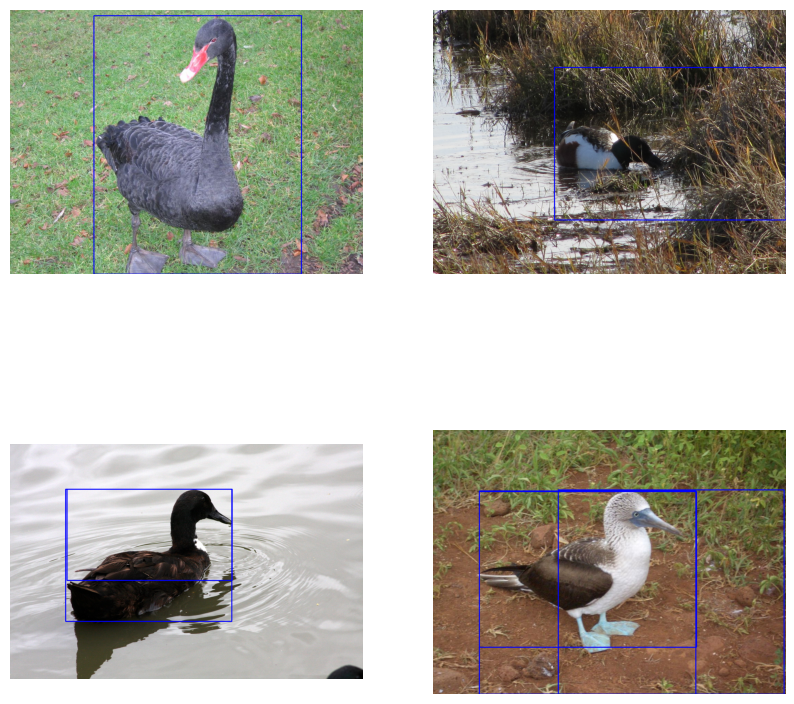

In [34]:
#  Visualize the results of one of the above model variants on 4 images from the validation set.
import matplotlib.pyplot as plt
image_filenames = [f for f in os.listdir(os.path.join(train1Dir, "images", "val")) if f.endswith(".png")]
random.shuffle(image_filenames)
image_filenames = image_filenames[:4]
images = []
for image in image_filenames:
    images.append(os.path.join(train1Dir, "images", "val", image))
results = trainedModel32.predict(images)
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
for i, (image, result) in enumerate(zip(images, results)):
        img = cv2.imread(image)
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = box
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        axis[i//2, i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axis[i//2, i%2].axis('off')

plt.show()


### Impact of Augmentations

Yes, the default configuration includes augmentations during the training process. These augmentations are designed to enhance the model's ability to generalize and perform well on unseen data by introducing variations in the training images. Here are the augmentations used along with their descriptions:

- Hue Adjustment (hsv_h): Modifies the hue of the image, aiding in color variability understanding across different lighting conditions.
- Left-Right Flip (fliplr): Flips the image horizontally with a specified probability, useful for symmetrical object learning.
- Scaling (scale): Scales the image to simulate objects at different distances from the camera.
- Saturation Adjustment (hsv_s): Alters the saturation of the image, affecting color intensity and simulating diverse environmental conditions.
- Shearing (shear): Shears the image to mimic objects viewed from different angles.
- Perspective Transformation (perspective): Applies a random perspective transformation to the image, improving 3D object understanding.
- Brightness Adjustment (hsv_v): Adjusts the brightness of the image, allowing the model to adapt to various lighting scenarios.
- Rotation (degrees): Randomly rotates the image within a specified degree range, helping the model recognize objects at different angles.
- Mosaic Combination (mosaic): Combines four training images into one, simulating diverse scene compositions.
- Translation (translate): Horizontally and vertically translates the image by a fraction of its size, aiding in detecting partially visible objects.
- Mixup (mixup): Blends two images and their labels, creating a composite image to introduce label noise and visual variability.
- Upside-Down Flip (flipud): Flips the image upside down with a specified probability, increasing data variability.
- Channel Flip (bgr): Flips image channels from RGB to BGR with a specified probability, enhancing robustness.


In [ ]:
%pip uninstall -y albumentations

Training the model aftere removing all augmentations

In [ ]:
model1 = YOLO('yolov8n.pt')
model1.train(data=config1path, epochs = 30, save = True, project = 'yolov8n_no_aug_train1',hsv_h = 0, hsv_s = 0, hsv_v = 0, degrees = 20, translate = 0, scale = 0.5 , fliplr= 0, mosaic= 0 )

Result Comparison

- With Augmentations


0: 640x640 (no detections), 64.2ms
1: 640x640 (no detections), 64.2ms
2: 640x640 (no detections), 64.2ms
3: 640x640 (no detections), 64.2ms
Speed: 11.4ms preprocess, 64.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


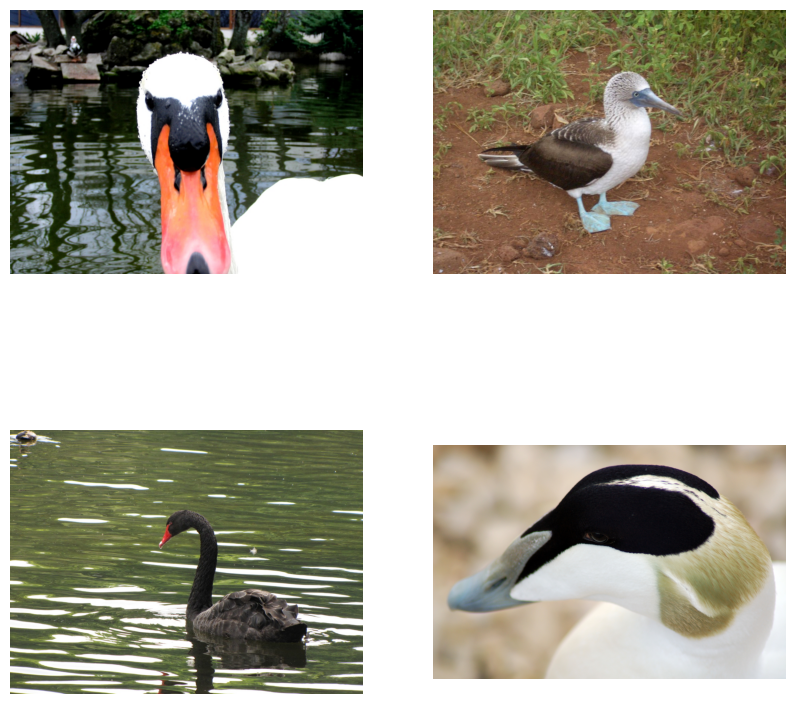

In [36]:
import matplotlib.pyplot as plt
image_filenames = [f for f in os.listdir(os.path.join(train1Dir, "images", "val")) if f.endswith(".png")]
random.shuffle(image_filenames)
image_filenames = image_filenames[:4]
images = []
for image in image_filenames:
    images.append(os.path.join(train1Dir, "images", "val", image))
results = trainedModel11.predict(images)
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
for i, (image, result) in enumerate(zip(images, results)):
        img = cv2.imread(image)
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = box
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        axis[i//2, i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axis[i//2, i%2].axis('off')


- Without Augmentations

0: 640x640 (no detections), 4.6ms
1: 640x640 (no detections), 4.6ms
2: 640x640 (no detections), 4.6ms
3: 640x640 (no detections), 4.6ms
Speed: 3.6ms preprocess, 4.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


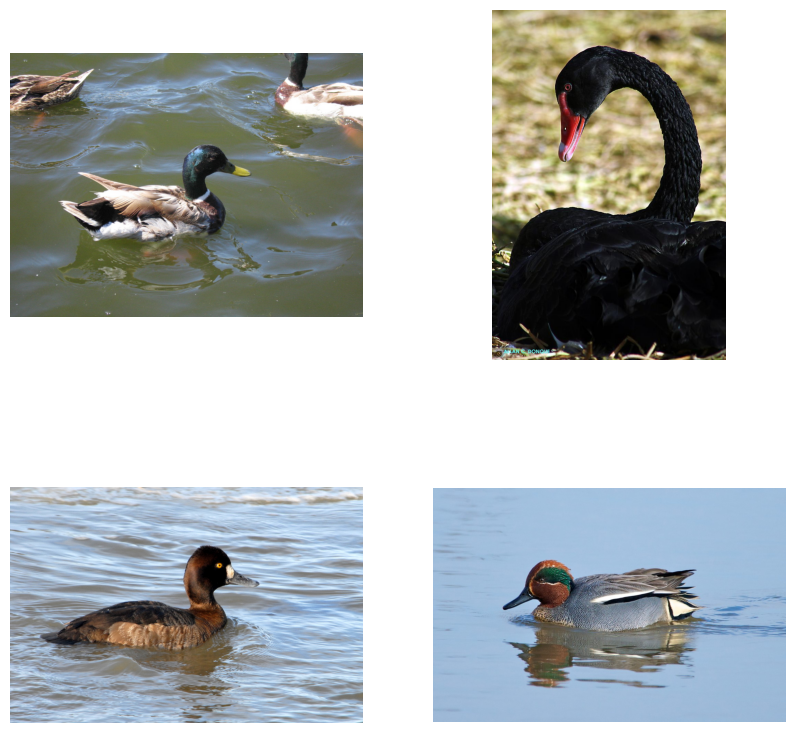

In [38]:
import matplotlib.pyplot as plt
model1 = YOLO('best.pt')
image_filenames = [f for f in os.listdir(os.path.join(train1Dir, "images", "val")) if f.endswith(".png")]
random.shuffle(image_filenames)
image_filenames = image_filenames[:4]
images = []
for image in image_filenames:
    images.append(os.path.join(train1Dir, "images", "val", image))
results = model1.predict(images)
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
for i, (image, result) in enumerate(zip(images, results)):
        img = cv2.imread(image)
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = box
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        axis[i//2, i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axis[i//2, i%2].axis('off')


- Training Classification Loss:
  - With Augmentation: 3.6885
  - Without Augmentation: 1.4705

- Validation mAP50 Scores:
  - With Augmnentation: 0.0761
  - Without Augmentation: 0.65293

The change is signficant as can be seen from the scores before and after removing augmentation.

### Determining the significant augmentation

In [ ]:
modelhsvh = YOLO('yolov8n.pt')
modelhsvh.train(data=config1path, epochs=30, save = True, project = 'yolov8n_hsv_h', hsv_h = 0)

In [ ]:
modelhsvs = YOLO('yolov8n.pt')
modelhsvs.train(data=config1path, epochs=30, save = True, project = 'yolov8n_hsv_s', hsv_s = 0)

In [ ]:
modelhsvv = YOLO('yolov8n.pt')
modelhsvv.train(data=config1path, epochs=30, save = True, project = 'yolov8n_hsv_v', hsv_v = 0)

In [ ]:
modeldeg = YOLO('yolov8n.pt')
modeldeg.train(data=config1path, epochs=30, save = True, project = 'yolov8n_degrees', degrees=20)

In [ ]:
modelFlip = YOLO('yolov8n.pt')
modelFlip.train(data=config1path, epochs=30, save = True, project = 'yolov8n_flip', fliplr=0)

In [ ]:
modelMosaic = YOLO('yolov8n.pt')
modelMosaic.train(data=config1path, epochs=30, save = True, project = 'yolov8n_mosaic', mosaic=0)

In [ ]:
modeltrans = YOLO('yolov8n.pt')
modeltrans.train(data=config1path, epochs=30, save = True, project = 'yolov8n_translate', translate=0.1)

In [ ]:
modelScale = YOLO('yolov8n.pt')
modelScale.train(data=config1path, epochs=30, save = True, project = 'yolov8n_scale', scale=0)

- Model HSV_H
  - Training Classification Loss: 1.4711
  - Validation Set mAP50: 0.63154

- Model HSV_V
  - Training Classification Loss: 1.3913
  - Validation Set mAP50: 0.64283

- Model HSV_S
  - Training Classification Loss: 1.4502
  - Validation Set mAP50: 0.67814

- Model Degrees
  - Training Classification Loss: 1.8392
  - Validation Set mAP50: 0.6961

- Model Flip
  - Training Classification Loss: 0.8379
  - Validation Set mAP50: 0.7563

- Model Mosaic
  - Training Classification Loss: 1.183
  - Validation Set mAP50: 0.695

- Model Translate
  - Training Classification Loss: 1.1034
  - Validation Set mAP50: 0.7477

- Model Scale
  - Training Classification Loss: 0.7695
  - Validation Set mAP50: 0.7247

- We obtain the best Scores if only translate augmentation is removed. 
- We obtain the least score if only HSV_H flag is removed.